In [40]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages')

In [2]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git
# !pip install RISE
import os
import math
import pandas as pd
import json
from pandas import json_normalize

import snscrape.modules.twitter as sntwitter
import itertools

from datetime import datetime
from random import randrange
import shutil

  Running command git clone -q https://github.com/JustAnotherArchivist/snscrape.git 'C:\Users\rk982\AppData\Local\Temp\pip-req-build-5mf1jbav'


  Cloning https://github.com/JustAnotherArchivist/snscrape.git to c:\users\rk982\appdata\local\temp\pip-req-build-5mf1jbav
  Created wheel for snscrape: filename=snscrape-0.4.1.20211214-py3-none-any.whl size=54377 sha256=75dbcb78287a3fd4c7e7a68292ede96cb92fd37ef51df2100b67e4c8b24610a8
  Stored in directory: C:\Users\rk982\AppData\Local\Temp\pip-ephem-wheel-cache-hsin70xx\wheels\92\42\87\33fa9b18f7a75d02643a9ca3743339aec9be28c6796267c7d8
Successfully built snscrape
  Attempting uninstall: snscrape
    Found existing installation: snscrape 0.4.0.20211209.dev3+g4b3c6ae
    Uninstalling snscrape-0.4.0.20211209.dev3+g4b3c6ae:
      Successfully uninstalled snscrape-0.4.0.20211209.dev3+g4b3c6ae


# PART 1: Tweet Data Collection

For this project, tweet data collection is broken down into three parts: creating a search parameter, scraping tweets from all counties in a state, and scraping tweets over multiple date ranges. 

## 1.1: Creating Search Parameter

The syntax for our Twitter scraping follows this pattern: ```[TERMS] near:[LOCATION] since:[DATE1] until:[DATE2]```. A new search parameter must be generated for each county and date range. 

We have four general search terms: coronavirus, covid19, pandemic, and quarantine. We want to find tweets that contain at least one of these four terms. Therefore, our ```[TERMS]``` look like this: ```"coronavirus" OR "covid19" OR "pandemic" OR "quarantine"```. To search using different terms or add/remove terms, we can modify that list ```search_terms```. 

```[LOCATION]``` is just the county name, which we take from a CSV for its respective state. ```[DATE1]``` and ```[DATE2]``` are the start date (inclusive) and end date (exclusive) for the search.

As an example, let's say we want to find tweets with any of our search terms in Los Angeles County between January 1st, 2020 and December 31st, 2020. The command would be: ```search_builder(search_terms, "Los Angeles", '2020-01-01', '2021-01-01')```.

The output would be: ```"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2021-01-01```

# Introduction

- The goal of our project:
    - Determine if there is a correlation between the sentiment within Tweets and an increase in Covid 19 Cases in the United States.
- Over 2 million Tweets were collected among four key State's over a nine week period
- The Hugging Face Sentiment Analysis was used on the content of each Tweet
- We graphically visualized our data using matplotlib
- And lastly ran our Machine Learning algorithm 

## Infrastructure for the product:

- Large amount of frequently updated data including COVID data and Tweets
- Updates are determined by Twitter and the rate of which each individual state <br>updates their COVID case data
- Seperate teams would have to established for separate states, or possibly regions
- Application would likely need to be hosted by a cloud platform such as AWS as the <br>amount of data could exceed what is capable on one machine
 

## Engineering demands for the product

- Small amount of data, i.e, a small state requires at least 8GB of RAM as well as a multi-core processor
- Having at least 50GB of hard drive space is recommended for smaller states
- Attempting to use the product across all regions may require a dedicated drive
- Ability to access data on demand when needed
- Secondary machine to only handle this product may be necessary as time to complete operation can reach <br>all the way to 10 hours and beyond
- Scale is a large factor of this product, as the scale is ultimately up to the user


## Data Formats and Tools

- Snscrape provides Tweet data such as hashtags, keywords, and users
- Individual COVID state data provides total cases, positive cases, reported tests, and other <br>useful information to be collected
- Sentiment analysis allows us to view the statistics on Tweet data regarding positivity or negativity <br>based on keywords and hashtags
- Using one location per Tweet data and state COVID data keeps results consistent with location

## Analytics Project as Application

- Allows a user to see how a state may feel in relative to their COVID cases
- Provides a way to view COVID cases and tests in a easily viewable format
- A user would access the platform hosting this product as handling the entire application would <br>be unfeasible for one user
- This is due to the rising potential scale of the product
- A user would likely use this product on a date basis, searching through a range of dates, which <br>could vary in time to completion
- Product would likely not be used for a one-off task since the data used is frequently updated and <br>becomes less relevant with time

### Twitter Data Gathering

- Our group scraped Twitter using an open-source tweet-scraper [SNScrape by JustAnotherArchivist](https://github.com/JustAnotherArchivist/snscrape)
- We scraped tweets from California, Florida, New York, and Texas since they are the most populated states
- Our process can be broken down into three parts
    1. Creating a search parameter
    2. Scraping and savings tweets from a select state
    3. Scraping tweets in a date range

### Twitter Data

- Formatted the Twitter data collected:
    - by week
    - by state
    - by county

In [3]:
ST_ABBR = ['ca', 'fl', 'ny', 'tx']

# Search terms: Content in the tweet
search_terms = [
    'coronavirus',
    'covid19',
    'pandemic',
    'quarantine',
]

# Creates a search parameter for the Twitter scraper
# since_date: inclusive
# until_date: exclusive
def search_builder(terms, area, since_date, until_date):    
    s = ''
    # Concatenate all search terms
    for i in range(len(terms) - 1):
        # NOTE: Inclusive OR statement
        s += '\"' + terms[i] + '\" OR '
    s += '\"' + terms[len(terms) - 1] + '\" '    
    
    # Within or the near the area
    s += 'near:\"' + area + '\" '
    # Since the first date
    s += 'since:' + since_date + ' '
    # Until the second date
    s += 'until:' + until_date
    
    return s

# Search for tweets in Los Angeles mentioning COVID terms
# from the beginning to the end of 2020.
los_angeles_search = search_builder(
    search_terms,
    "Los Angeles",
    '2020-01-01',
    '2021-01-01')

print(los_angeles_search)

"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2021-01-01


## 1.2 Save and Scrape by State

We can now scrape tweets from each county in a single state. To do so, we first need all the counties of the state, which can be found in ```data/counties``` in a CSV file (e.g., California counties = ```ca_counties.csv```). Then, we take a county and put it into our search builder along with the search's date range to generate a search parameter. Next, we put the search parameter and maximum number of tweets we want from each county into the tweet scraper, which will return a dataframe. This dataframe called ```county_tweets``` has more information than we need for our project so we only keep the following fields: date, content, renderedContent, user, and hashtags.

After this, we convert ```county_tweets``` into a JSON file following the name pattern ```[COUNTY_NAME].json```. Then, we move the JSON file into its correct subdirectory based on the date range it was scraped from and what state it belongs to. For example, tweets scraped from Alameda County, California between August 1st, 2021 and August 7th, 2021 will be put into a JSON named ```Alameda.json``` and placed into directory ```data/tweets/2021-08-01_2021-08-08/ca_tweets```.

This process will be repeated for all counties in the given state and date range.

In [3]:
# Returns a DataFrame with at most tweet_limit tweets resulting from
# the search
def scrape(search_param, tweet_limit):
    return pd.DataFrame(itertools.islice(
        sntwitter.TwitterSearchScraper(search_param).get_items(), tweet_limit))

# ********* STATE TWEET SCRAPING *********
# state: State to scrape
# abbr: State abbreviation
# limit: Maximum number of tweets to scrape from a county
# since_date: Start date to scrape (inclusive)
# until_date: End date to scrape (exclusive)
# display_all (optional): Display scrape status per county
def state_scraper(state, abbr, limit, since_date, until_date, display_all = False):        
    
    total_tweets = 0

    print("Compiling tweets (max <=" + str(limit) + ") from " + state + " counties from " 
          + since_date + " to " + until_date)

    print("START: " + str(datetime.now()))

    counties = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    for i in range(len(counties)):

        county = counties.iloc[i]['County']
        county.strip()

        county_search = search_builder(
            search_terms,
            county + " County, " + abbr,
            since_date,
            until_date)
        
        county_tweets = scrape(county_search, limit)

        if len(county_tweets) != 0:
            county_tweets = county_tweets[['date', 'content', 'renderedContent', 'user', 'hashtags']]
        
        total_tweets = total_tweets + len(county_tweets)

        # Generates JSON with respective county tweet data
        county_json = county_tweets.to_json(county + ".json", lines=True, orient='records')

        source = os.getcwd() + "/" + county + ".json"
        # Move to respective directory
        destination = '%s/data/tweets/%s_%s/%s_tweets/%s.json' % (os.getcwd(), since_date, until_date, abbr, county)
        shutil.move(source, destination)

        if display_all:
            print('(%d/%d) %s - %d tweets: %s' % (i + 1, len(counties), county, len(county_tweets), str(datetime.now())))
            
    print("END: " + str(datetime.now()))
    print(str(total_tweets) + " tweets processed")

Here are wrapper functions for California, Florida, New York, and Texas tweet scrapers. These exist simply for code readability.

In [ ]:
# California Tweet Scraper
def ca_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("California", "CA", tweet_limit, since_date, until_date, display_all = display_all)

# Florida Tweet Scraper
def fl_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("Florida", "FL", tweet_limit, since_date, until_date, display_all = display_all)

# New York Tweet Scraper
def ny_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("New York", "NY", tweet_limit, since_date, until_date, display_all = display_all)
    
# Texas Tweet Scraper
def tx_scraper(tweet_limit, since_date, until_date, display_all = False):
    state_scraper("Texas", "TX", tweet_limit, since_date, until_date, display_all = display_all)

The function ```scrape_all``` performs two important tasks. Firstly, it creates the date range directory that will hold the state subdirectories, which hold all the county tweets. Second, it calls the four defined state scrapers, which will save the county tweets in the directories previously stated. 

In [ ]:
# Scrape all selected states
def scrape_all(tweet_limit, since_date, until_date, display_all = False):
    
    try:
        # Create date range directory
        os.mkdir('data/tweets/%s_%s' % (since_date, until_date))
        
        print("Directory for range %s to %s does not exist. Creating now and populating..." % (since_date, until_date))

        # Create California subdirectory
        os.mkdir('data/tweets/%s_%s/ca_tweets' % (since_date, until_date))
        # Create Florida subdirectory
        os.mkdir('data/tweets/%s_%s/fl_tweets' % (since_date, until_date))
        # Create New York subdirectory
        os.mkdir('data/tweets/%s_%s/ny_tweets' % (since_date, until_date))
        # Create Texas subdirectory
        os.mkdir('data/tweets/%s_%s/tx_tweets' % (since_date, until_date))
    except FileExistsError:
        print("Directory for range %s to %s already exists." % (since_date, until_date))

    ca_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    fl_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    ny_scraper(tweet_limit, since_date, until_date, display_all = display_all)
    tx_scraper(tweet_limit, since_date, until_date, display_all = display_all)

## 1.3 Scraping over Date Ranges

We've gone over search terms and locations. Now, we need to incorporate the date range. Our team has decided to scrape nine weeks worth of tweets between August 1st, 2021 to December 10th, 2021. To achieve this, we define a lower bound date ```current_start``` and upper bound date ```current_end```, scrape all states using this range, then move the boundaries up by seven days. This process results in over two million tweets getting scraped and filed into nine date range directories and four state directories per date range.

In [44]:
#----- WARNING------------------------------------------------------------------
# RUNNING THIS CELL WILL START DATA COLLECTION. 
# RUNTIME = ~12 HOURS
#----- WARNING------------------------------------------------------------------

from datetime import timedelta

start_time = datetime.strptime("2021-08-01", "%Y-%m-%d")
end_time = datetime.strptime("2021-08-08", "%Y-%m-%d")

weeks_count = 8

# Scrape tweets from 08/01 to 09/26
for i in range(weeks_count):
    
    current_start = (start_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    current_end = (end_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    
    # Scrape 1000 tweets from each county of each state
    scrape_all(1000, current_start, current_end)

Directory for range 2021-08-01 to 2021-08-08 already exists.
Compiling tweets (max <=1000) from California counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:45:21.929392
END: 2021-12-13 22:49:52.254917
11337 tweets processed
Compiling tweets (max <=1000) from Florida counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:49:52.256917
END: 2021-12-13 22:55:54.427091
15639 tweets processed
Compiling tweets (max <=1000) from New York counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 22:55:54.429094
END: 2021-12-13 23:02:20.789729
15682 tweets processed
Compiling tweets (max <=1000) from Texas counties from 2021-08-01 to 2021-08-08
START: 2021-12-13 23:02:20.791727
END: 2021-12-14 00:11:28.287382
207660 tweets processed
Directory for range 2021-08-08 to 2021-08-15 already exists.
Compiling tweets (max <=1000) from California counties from 2021-08-08 to 2021-08-15
START: 2021-12-14 00:11:28.290381
END: 2021-12-14 00:16:19.258796
11342 tweets processed
Compiling tweets 

In [90]:
#----- WARNING------------------------------------------------------------------
# RUNNING THIS CELL WILL START DATA COLLECTION. 
# RUNTIME = ~1 HOURS
#----- WARNING------------------------------------------------------------------

# One more week for 2 million entries
# Scrape from 09/26 to 10/03 

current_start = (start_time + timedelta(days = 8 * 7)).strftime("%Y-%m-%d")
current_end = (end_time + timedelta(days = 8 * 7)).strftime("%Y-%m-%d")
    
# Scrape 1000 tweets from each county of each state
scrape_all(1000, current_start, current_end)

Directory for range 2021-09-26 to 2021-10-03 already exists.
Compiling tweets (max <=1000) from California counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 14:49:45.425344
END: 2021-12-14 14:54:52.643010
11212 tweets processed
Compiling tweets (max <=1000) from Florida counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 14:54:52.645012
END: 2021-12-14 15:01:11.346188
15372 tweets processed
Compiling tweets (max <=1000) from New York counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 15:01:11.348183
END: 2021-12-14 15:07:36.329638
15286 tweets processed
Compiling tweets (max <=1000) from Texas counties from 2021-09-26 to 2021-10-03
START: 2021-12-14 15:07:36.331634
END: 2021-12-14 16:18:25.143407
207299 tweets processed


The snippet below sums up all the tweets scraped across all states. We have gathered 2,248,336 tweets mentioning COVID-19 across California, Florida, New York, and Texas. 

In [6]:
from datetime import timedelta

counties = {}

for abbr in ST_ABBR:
    
    csv = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    counties[abbr] = []
    
    for i in range(len(csv)):

        county = csv.iloc[i]['County']
        county.strip()
        
        counties[abbr].append(county)
                
start_time = datetime.strptime("2021-08-01", "%Y-%m-%d")
end_time = datetime.strptime("2021-08-08", "%Y-%m-%d")

range_total = 0
total_tweets = 0

weeks_count = 9

for i in range(weeks_count):
    
    range_total = 0
    
    current_start = (start_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    current_end = (end_time + timedelta(days = i * 7)).strftime("%Y-%m-%d")
    
    for abbr in ST_ABBR:
        
        for county in counties[abbr]:
            for line in open('data/tweets/%s_%s/%s_tweets/%s.json' % (current_start, current_end, abbr, county)):
                range_total += 1
                total_tweets += 1
    print('%s to %s tweets = %d' % (current_start, current_end, range_total))
    
print('Total tweets = %d' % total_tweets)       

2021-08-01 to 2021-08-08 tweets = 250394
2021-08-08 to 2021-08-15 tweets = 250597
2021-08-15 to 2021-08-22 tweets = 249925
2021-08-22 to 2021-08-29 tweets = 250056
2021-08-29 to 2021-09-05 tweets = 249586
2021-09-05 to 2021-09-12 tweets = 249439
2021-09-12 to 2021-09-19 tweets = 249623
2021-09-19 to 2021-09-26 tweets = 249460
2021-09-26 to 2021-10-03 tweets = 249256
Total tweets = 2248336


In [92]:
# Combining Each States Json Tweet files to a single pandas dataframe
import re

def file_paths(folder_path):
    # Stack overflow solution to finding only files in a directory using os.walk, previous attempt used listdir.
    # Article: https://stackoverflow.com/questions/52338706/isadirectoryerror-errno-21-is-a-directory-it-is-a-file
    path_list = [os.path.join(path, file) 
                      for path, directory, files in os.walk(folder_path) for file in files]
    return path_list

# Combine JSON files for efficiency then make a single dataframe.

# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def json_to_dataFrame(json_folder_path, json_folder_list, output_file):
    file_path_list = []
    for json_folder in json_folder_list:
        file_path_list.extend(file_paths('data/tweets/' + json_folder + json_folder_path))
 
    combined_json_file = 'data/tweets/results/' + output_file
# Stack overflow solution for combining json files. Combining json files was suggested as more efficient than
#  dataframes. Combines the json files into record oreint/format. 
# Article: https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
    with open(combined_json_file, 'w') as combined_files:
        combined_files.write("{}".format("".join([open(file, "r").read() for file in file_path_list])))
# Dataframe using orient records because this was the specific formating used to collect the data. 
    dataframe = pd.read_json(combined_json_file, lines=True, orient='records')

    return dataframe

folder_list = ['2021-08-01_2021-08-08/', '2021-08-08_2021-08-15/', '2021-08-15_2021-08-22/', 
               '2021-08-22_2021-08-29/', '2021-08-29_2021-09-05/', '2021-09-05_2021-09-12/', 
               '2021-09-12_2021-09-19/', '2021-09-19_2021-09-26/', '2021-09-26_2021-10-03/']

### State Covid 19 Case Data Sources

- We've collected our State Covid 19 Case data from two sources.
    - Official State Websites
    - Centers for Disease Control(CDC)
- The main reason was to make the automation of our data visualization easier. 
    - All of our data is from comma-separated value(CSV) files
    - All the data has a date, county, and case/positive test columns
- California and New York had their data listed on their website in the format we wanted.
- Texas and Florida didn't:
    - We took their information from the CDC
    - With this we can technically automate all or our Covid 19 Case data 


### Dealing with Tweet Json Files

- Upon scrapping the Tweet data from Twitter we organized the data into folders referencing the weeks they were scrapped from.
<div>
    <img src='data/images/week_formated_folder.png' alt='Week Formated Folders', width='900'}/>
</div>
- We combined the individual county files using our json_to_dataFrame function for each State.

``` python 
    ca_df = json_to_dataFrame('ca_tweets', folder_list, 'ca_results.json') 
```

### Dealing with Tweet Json Files : Texas Specific

- That being said, for the Texas Tweets, to reduce the time constraints for the sentiment analysis we combined the county Tweets for each week instead of all of them.
    - Our previously mentioned ``` json_to_dataFrame ``` function was able to still collect every tweet during a single week instead of the full nine:
    ```python
    json_to_dataFrame('tx1_tweets', [week_1], 'tx1_results.json') 
    ```
- In Comparison to the other States, Texas alone accounted for 83% of our Twitter data.
<div>
    <img src='data/images/texas_tweet_comparison.png' alt='Texas Comparison' width='500'/>
</div>

In [5]:
# Sentiment testing with HuggingFace
# Pip install the transfomers with Pytorch specifically. 
# !pip install transformers[torch]
from transformers import pipeline

def sentiment_analysis(dataframe):
    # Added print timeframe from State Scrapper
    print("START: " + str(datetime.datetime.now())[11:19])
    
    # Construct pipeline using sentiment-analysis to mesaure "sentiment" of tweet content
    classifier = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

    # Create empty list to collect sentiment values
    sentiment_list = []
    # For loop to take twitter content and analyze for sentiment values.
    for content in dataframe['content']:
        content_sentiment = classifier(content)
        # # Formated sentiment score
        # content_sentiment[0]['score'] = "{:.2f}%".format(content_sentiment[0]['score'] * 100)
        # # Append each new content sentiment to the list.
        # sentiment_list.append(content_sentiment[0])
        sentiment_list.append(content_sentiment[0]['label'])
        
    # Copy dataframe
    df_copy = dataframe.copy()
    
    # Added print timeframe from State Scrapper
    print("End: " + str(datetime.datetime.now())[11:19])
    # assign the new sentiment list values to the dataframe titled sentiment
    return df_copy.assign(sentiment = sentiment_list)

### Analyzing Sentiment of Twitter Content

- This portion of our project was the most time intensive. On average the Hugging Face sentiment analysis took around two hours to analyze 100K records.
    - For reference: 
        - ***California*** took 126 minutes (2 hours & 6 minutes) to process 101,403 records: **~805 records/minute**
        - ***Florida*** took 172 minutes (2 hours & 52 minutes) to process 139,048 records: **~808 records/minute**
        - ***New York*** took 170 minutes (2 hours & 50 minutes) to process 139,605 records: **~821 records/minute**
    - We can't say for certain that this trend is accurate since it doesn't take certain factors such as the average Tweet content length into account for each State.  

### Analyzing Sentiment of Twitter Content: continued

- We automated the analysis process by using our ```sentiment_analysis()``` function.
    - It takes a Pandas dataframe and returns one with a sentiment column identifying NEGATIVE or POSITIVE Tweets.
    - We saved the sentiment data into a CSV file for future use.
    ```python
        ca_sentiment_df = sentiment_analysis(ca_df)
        ca_sentiment_df.to_csv('data/tweets/sentiment/cs_sentiment.csv', index=False)
        ca_sentiment.head()
    ```
<div>
    <img src='data/images/sentiment_analyzed_data.png' alt='Sentiment Analyzed Data Ex.' width='800'/>
</div>

In [6]:
ca_sentiment_df = pd.read_csv('data/tweets/sentiment/ca_sentiment.csv')
# ca_sentiment_df.head()

In [7]:
fl_sentiment_df = pd.read_csv('data/tweets/sentiment/fl_sentiment.csv')
# fl_sentiment_df.head()

In [8]:
ny_sentiment_df = pd.read_csv('data/tweets/sentiment/ny_sentiment.csv')
# ny_sentiment_df.head()

### Analyzing Sentiment of Twitter Content: Issue with Texas Data

- Because of the sheer amount of Tweets, the Texas data was treated slightly differently.
    - The individual weeks were analyzed requiring us to combine the separate sentiment files before proceeding.
<div>
    <img src='data/images/tx_sentiment_files.png', alt='Texas Sentiment Files' width='700'/>
</div>
    - For this reason we wrote a ``` combine_sentiment_csv ``` function for this situations and can be repurposed for the future.
- This resulted in a single 2 GB ``` 'tx_sentiment.csv' ``` file using:
    ```python
    combine_sentiment_csv('data/tweets/sentiment', 'tx_sentiment.csv', 'tx')
    ```

In [9]:
# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def combine_sentiment_csv(csv_folder_path, output_file, state_ab):
    file_path_list = []
    file_path_list.extend(file_paths(csv_folder_path))
    new_path_list = []
    i = 0
    for file in file_path_list:
        if state_ab in file:
            new_path_list.append(file)
    new_path_list.sort()
    new_csv_path = 'data/tweets/sentiment/' + output_file
    with open(new_csv_path, 'w') as output:
        for i in range(len(new_path_list)):
            if i == 0:
                file = open(new_path_list[i]) 
            else:
                file = open(new_path_list[i])
                next(file)
            for line in file:
                output.write(line)

In [10]:
tx_sentiment_df = pd.read_csv('data/tweets/sentiment/tx_sentiment.csv')
# tx_sentiment_df

### Data Formatting Issue

- An issue we faced before visualizing our data graphically involved the date's in the ``` 'date' ``` column. 
    - Original Format: ``` Year-Month-Day Hour:Minute:Seconds ```
- We're grouping our data by days so the specific time wasn't necessary. 
- Using our ``` datetime_to_date ``` function we could deal with that.
    - New Format: ``` Year-Month-Day ```
- Side note, depending on whether you load the sentiment data from the saved csv files the format may be strings or datetime objects, our code accomadates for this.
    <div>
        <img src='data/images/datetime_to_date_function.png' alt='datetime_to_date function' width='500'/>
    </div>

In [11]:
# Fix date column to remove time from datetime for data visualization
def datetime_to_date(dataframe2):
    print("Start: " + str(datetime.datetime.now())[11:])
    df2_copy = dataframe2.copy()
    datetime_list = []
    for dt in dataframe2['date']:
        # # Uncomment Line below for datetime to date conversion
        # datetime_list.append(dt.date())
        # # Comment Line below for datetime to date conversion
        datetime_list.append(dt[:10])
    new_date = pd.DataFrame(data={'date' : datetime_list})
    df2_copy['date'] = new_date['date']
    print("End: " + str(datetime.datetime.now())[11:])
    return df2_copy

In [12]:
ca_date_formatted_df = datetime_to_date(ca_sentiment_df)

Start: 22:12:58.623589
End: 22:12:58.674617


In [13]:
fl_date_formatted_df = datetime_to_date(fl_sentiment_df)

Start: 22:12:59.170500
End: 22:12:59.242136


In [14]:
ny_date_formatted_df = datetime_to_date(ny_sentiment_df)

Start: 22:12:59.713000
End: 22:12:59.791001


In [15]:
tx_date_formatted_df = datetime_to_date(tx_sentiment_df)

Start: 22:13:00.341740
End: 22:13:01.025256


## Graphical Data Visualization and Summary Stats

- Going forward we graphically visualized our two groups of data using matplotlib
    - The Sentiment data is visualized using bar graphs
        - mapping the number of ***NEGATIVE*** & ***POSITIVE Tweets*** per week
    - The Covid 19 Case data is visualized using line graphs
        - mapping the number of ***Cases*** per week


### Sentiment Visulaization

- We chose to visualize the sentiment of each States Tweets over the 9 weeks separately.
    - We'll showcase California, Florida, New York, and Texas in that order
    - This visualization uses bar graphs because we wanted to compare the sentiment of the Tweets over the 9 weeks.
- Each graph visually represents the total ***POSITIVE*** and ***NEGATIVE Tweets*** as either ***blue*** or ***red*** bars for each week.
- It should be noted that we chose to separate the graphes because of the number of total tweets collected from each State varied greatly over the 9 weeks.
    - I.e. Week 4: 11,303 (California) vs 207,520 (Texas) tweets

In [16]:
import matplotlib.pyplot as plt
import datetime

list_of_dates = []
negative_x = []
x_tick_labels = []
# Visualizes data based on formatted dataframes for date and sentiment...
def sentiment_visualization(formatted_df, state):
    # Seperate the data based on sentiment.
    neg_sentiment_df = formatted_df.loc[formatted_df['sentiment']=='NEGATIVE']
    pos_sentiment_df = formatted_df.loc[formatted_df['sentiment']=='POSITIVE']
    # Collect unique date values
    neg_set_of_dates = set(neg_sentiment_df['date'])
    pos_set_of_dates = set(pos_sentiment_df['date'])
    set_of_dates = neg_set_of_dates.union(pos_set_of_dates)
    # added an additional date value at the end to assist in visualization issues during development.
#     set_of_dates.add(max(set_of_dates) + datetime.timedelta(days=1))
    set_of_dates.add(max(set_of_dates))
    # Sort dates
    list_of_dates = sorted(list(set_of_dates))
    # Create X and Y values lists for Negative sentiments.
    negative_x = []
    negative_y = []
    x_value = 0
    y_value = 0
    for i in range(len(list_of_dates)+1):
        if (i>0 and i%7 == 0) and i < len(list_of_dates):
            negative_x.append(int((x_value)/7))
            negative_y.append(y_value)
            x_value = x_value + 1
            y_value = len(neg_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
        elif i == len(list_of_dates):
            negative_x.append(int((x_value)/7))
            negative_y.append(y_value)
        else:
            x_value = x_value + 1
            y_value = y_value + len(neg_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
    # Create X and Y values lists for Positive sentiments.
    positive_x = []
    positive_y = []
    x_value = 0
    y_value = 0
    for i in range(len(list_of_dates)+1):
        if (i>0 and i%7 == 0) and i < len(list_of_dates):
            positive_x.append(int((x_value)/7) - 0.5)
            positive_y.append(y_value)
            x_value = x_value + 1
            y_value = len(pos_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
        elif i == len(list_of_dates):
            positive_x.append(int((x_value+1)/7) - 0.5)
            positive_y.append(y_value)
        else:
            x_value = x_value + 1
            y_value = y_value + len(pos_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
    # Reference: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-
    # the-bar-on-each-bar-with-pyplot-barh
    # User: Franck Dernoncourt
    # Code referenced for textual values in the bar graph
    
    # Create plot and assign figure size
    fig, axs = plt.subplots(figsize=(20,6))
    # Convert datetime dates to strings to assign to the 'x ticks' on the plot graph
    x_tick_labels = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8', 'Week 9']

    # General bar width
    bar_widths = 0.25
    # Seperatly creating both bar plots and assign to the same subplot
    negative_bar = axs.bar(negative_x, negative_y, width=1/2, align='edge', color='red', 
                           label='Negative')
    positive_bar = axs.bar(positive_x, positive_y, width=1/2, align='edge', color='blue', 
                           label='Positive')
    # Label bar graph values
    barlabels(negative_bar, axs)
    barlabels(positive_bar, axs)
    # Label x tick values
    plt.xticks(negative_x, x_tick_labels)
    axs.set_title((state + ' Sentiment Visulaization'), fontsize=20)
    axs.set_xlabel('Weeks 1-9 (Aug 01 - Oct 03)', fontsize=16)
    axs.set_ylabel('Sentiment Counts', fontsize=16)
    plt.legend()
    plt.show()
    return list_of_dates, negative_x, x_tick_labels
# Function used to label the bar graph values 
def barlabels(bar_graph, axs):
    for bar in bar_graph:
        if bar.get_height() > 0:
            bar_height = bar.get_height()
            axs.text(bar.get_x() + bar.get_width()/2, bar_height, '%d' % int(bar_height),
                     ha='center', va='bottom')

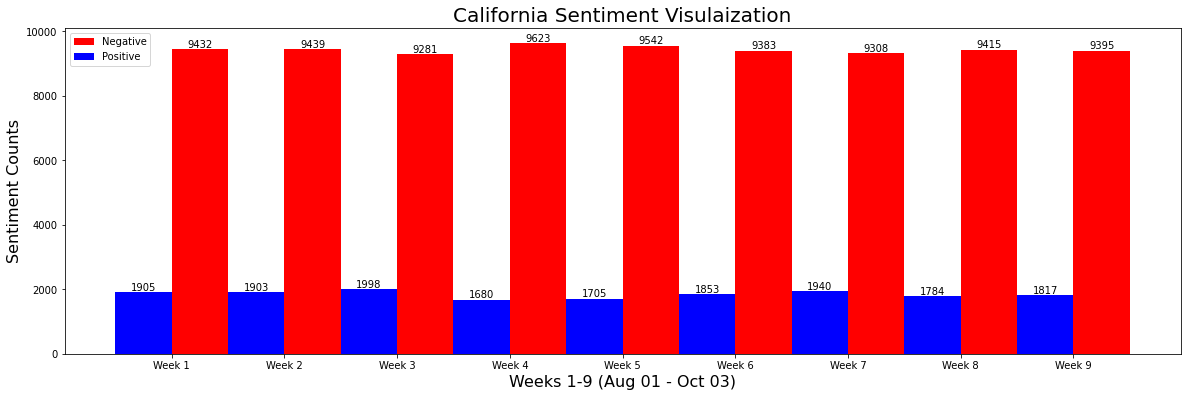

In [17]:
ca_date_list, ca_x_list, ca_x_labels = sentiment_visualization(ca_date_formatted_df, 'California')

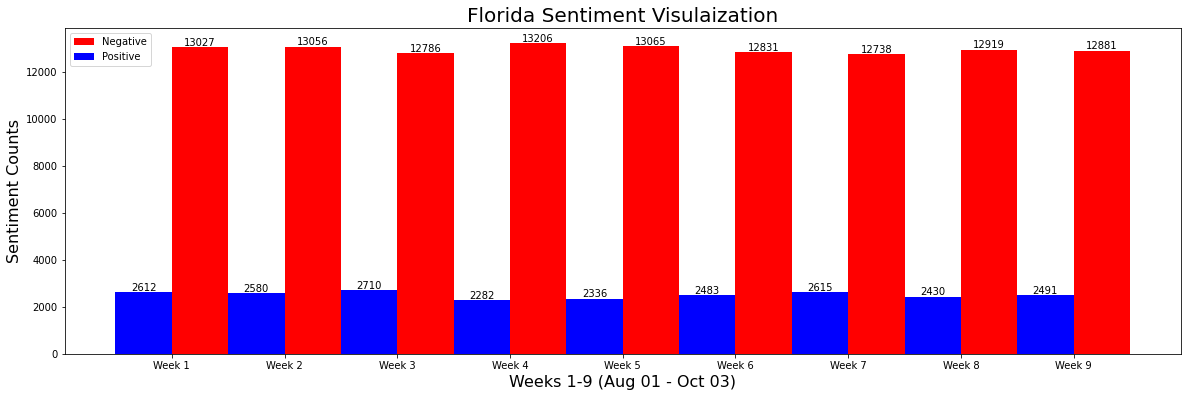

In [18]:
fl_date_list, fl_x_list, fl_x_labels = sentiment_visualization(fl_date_formatted_df, 'Florida')

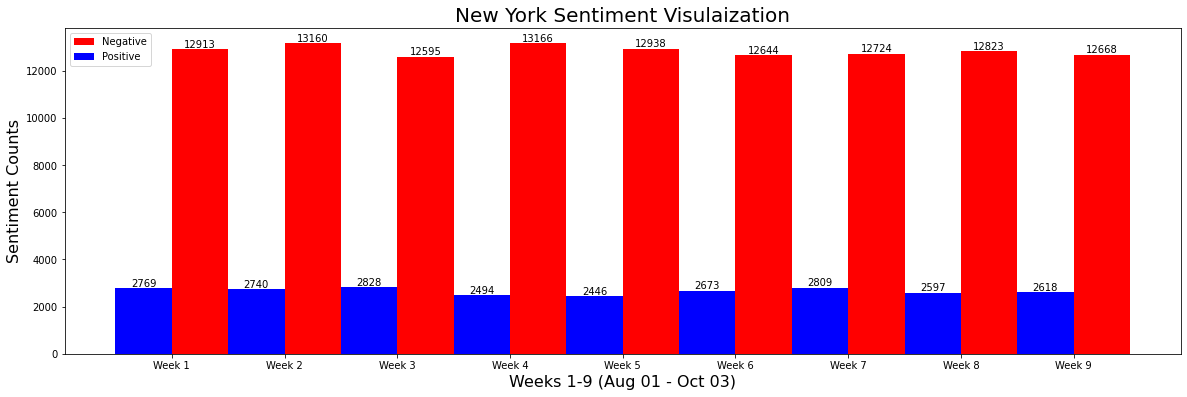

In [19]:
ny_date_list, ny_x_list, ny_x_labels = sentiment_visualization(ny_date_formatted_df, 'New York')

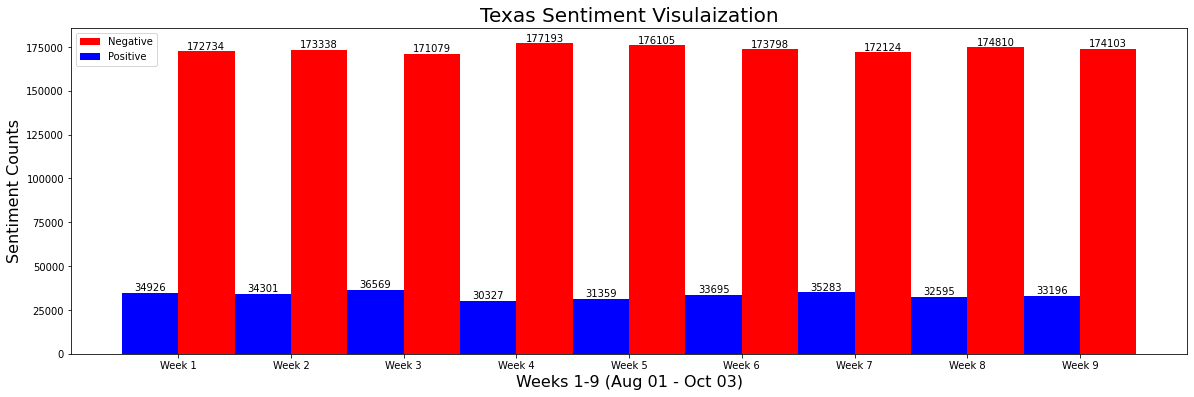

In [20]:
tx_date_list, tx_x_list, tx_x_labels = sentiment_visualization(tx_date_formatted_df, 'Texas')

### Covid 19 State Case Visualization

- Similar to the sentiment visualization, we chose to seperate the Covid 19 case data for consistency reasons.
    - In this case, we chose to visualize the data as line graphs to showcase a change in the trend of cases.
- Unlike the sentiment visualization, each State's Covid 19 Case data wasn't formatted the same requiring different methods of producing the graphical visualizations.
    - Thanks to this, we produced two visualization functions:
        - ``` cdc_state_case_visualization ```
        - ``` state_case_visualization ```
    - The former is written for any CDC State case file in mind while the latter functions around any State case file with defined case, county, and date columns. 

In [21]:
def str_to_date(covid_dataframe, column_name, date_format):
    c_df_copy = covid_dataframe.copy()
    new_date_list = []
    for dt in covid_dataframe[column_name]:
        new_date_list.append(datetime.datetime.strptime(dt, date_format))
    new_date_df = pd.DataFrame(data={'date' : new_date_list})
    c_df_copy[column_name] = new_date_df['date']
    c_df_copy = c_df_copy.rename(columns={column_name: "date"})
    return c_df_copy

def cdc_state_case_visualization(cases_df, date_list, x_list, x_labels, state, axs_name):
    cases_list = []
    # Iterate through the list of days 
    week_count = 0
    index = 1
    for date in date_list:
    # Select case data based on the defined days
        if index%7 == 0 and index < len(date_list):
            cases_list.append(week_count)
            index = index + 1
            week_count = int(cases_df.loc[cases_df["date"] == str(date)]['New Cases'])
        elif index == len(date_list):
            week_count = week_count + int(cases_df.loc[cases_df["date"] == str(date)]['New Cases'])
            cases_list.append(week_count)
        else:
            week_count = week_count + int(cases_df.loc[cases_df["date"] == str(date)]['New Cases'])
            index = index + 1

    # Testing graphical output of matplotlib... 
    # Line Graph version
    cases_line = axs_name.plot(x_list, cases_list, 'o-', alpha=0.4, color='black', label='Cases')

    for point in range(int(len(ca_date_list)/7)):
        axs_name.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))

    fl_cases_axs.set_title(state + ' Cases', fontsize=20)
    fl_cases_axs.set_xlabel('Dates', fontsize=16)
    fl_cases_axs.set_ylabel('Case Counts', fontsize=16)
    plt.xticks(x_list, x_labels)
    plt.legend()
    plt.show()
    
def state_case_visualization(cases_df, counties_list, date_list, x_list, x_labels, county_label,
                             cases_label, state, axs_name):
    cases_list = []
    # Iterate through the list of days 
    week_count = 0
    index = 1
    for date in date_list:
    # Select case data based on the defined Counties and days
        if index%7 == 0 and index < len(date_list):
            index = index + 1
            cases_list.append(week_count)
            formatted_covid_df = cases_df[cases_df['date'].isin([str(date)])]
            county_covid_cases = formatted_covid_df[formatted_covid_df[county_label].isin(list(counties_list['County']))]
            week_count = int(sum(list(county_covid_cases[cases_label])))
        elif index == len(date_list):
            formatted_covid_df = cases_df[cases_df['date'].isin([str(date)])]
            county_covid_cases = formatted_covid_df[formatted_covid_df[county_label].isin(list(counties_list['County']))]
            week_count = week_count + int(sum(list(county_covid_cases[cases_label])))
            cases_list.append(week_count)
        else: 
            index = index + 1
            formatted_covid_df = cases_df[cases_df['date'].isin([str(date)])]
            county_covid_cases = formatted_covid_df[formatted_covid_df[county_label].isin(list(counties_list['County']))]
            week_count = week_count + int(sum(list(county_covid_cases[cases_label])))

    # Line Graph version
    cases_line = axs_name.plot(x_list, cases_list, 'o-', alpha=0.4, color='black', label='Cases')
    # Reference: https://stackoverflow.com/questions/22272081/label-python-data-points-on-plot
    # User: falsetru
    for point in range(int(len(date_list)/7)):
        axs_name.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))
    # # Bar Graph equivalence.
    # cases_bar = axs_name.bar(x_list, cases_list, width= 0.5, alpha=0.4, color='black', label='Cases')
    # barlabels(cases_bar, axs_name)

    axs_name.set_title(state + ' Cases', fontsize=20)
    axs_name.set_xlabel('Dates', fontsize=16)
    axs_name.set_ylabel('Case Counts', fontsize=16)
    plt.xticks(x_list, x_labels)
    plt.legend()
    plt.show()

C:\Users\rk982\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


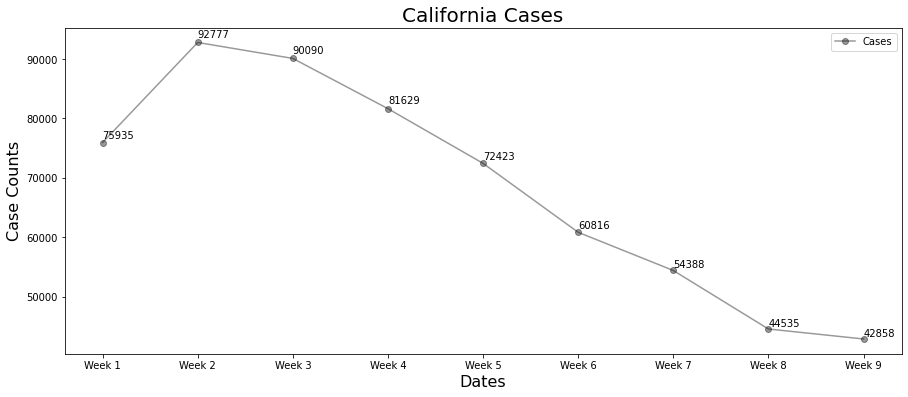

In [30]:
# California Case File from: https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
ca_covid_df = pd.read_csv("data/covid_data/ca_covid19_cases.csv")
# Drop majority of columns 
ca_covid_df = ca_covid_df.drop(['area_type', 'cumulative_cases', 'cumulative_deaths', 'cumulative_total_tests', 
                                'cumulative_positive_tests', 'cumulative_reported_cases', 
                                'cumulative_reported_deaths'], axis=1)
# Testing graphical output of matplotlib... 
ca_cases_fig, ca_cases_axs = plt.subplots(figsize=(15,6))
# Read counties csv
ca_counties = pd.read_csv("data/counties/ca_counties.csv")
state_case_visualization(ca_covid_df, ca_counties, ca_date_list, ca_x_list, ca_x_labels, 
                         'area', 'cases', 'California', ca_cases_axs)

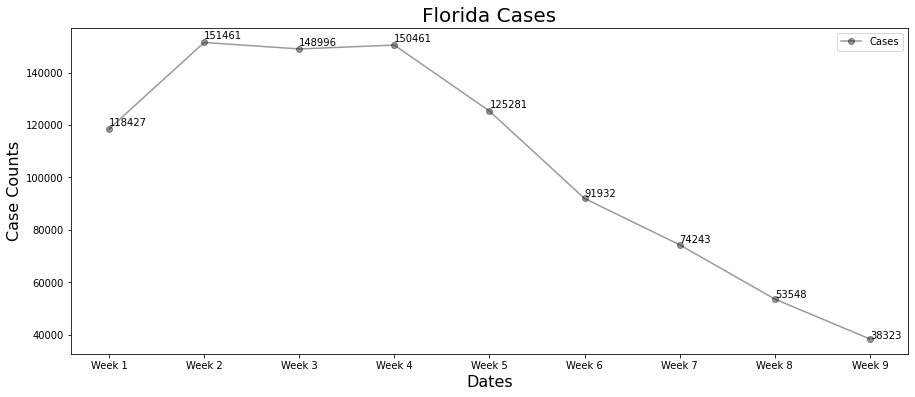

In [31]:
# FL Covid Case File from: https://covid.cdc.gov/covid-data-tracker/#trends_dailytr
#  endscases&territory-select=12&leftAxis=New_case&rightAxis=select
fl_covid_df = pd.read_csv("data/covid_data/fl_covid19_cases.csv", header=2)
fl_cases_df = str_to_date(fl_covid_df, 'Date', '%b %d %Y')

fl_cases_fig, fl_cases_axs = plt.subplots(figsize=(15,6))
cdc_state_case_visualization(fl_cases_df, fl_date_list, fl_x_list, fl_x_labels, 'Florida', fl_cases_axs)

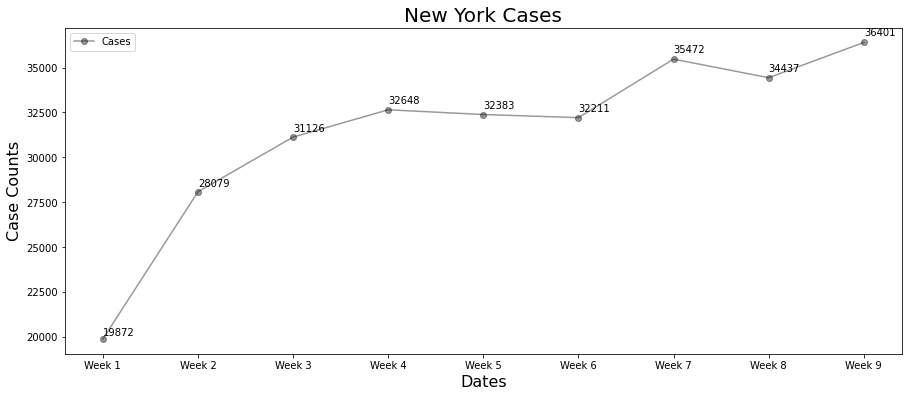

In [32]:
# NY Covid Case File from: https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e/data
ny_covid_df = pd.read_csv("data/covid_data/ny_covid19_cases.csv")

ny_cases_df = str_to_date(ny_covid_df, 'Test Date', '%m/%d/%Y')

    cases_list.append(sum([float(x) for x in county_covid_cases['cases']]))
        
# Testing graphical output of matplotlib... 
ny_cases_fig, ny_cases_axs = plt.subplots(figsize=(15,6))
# Read counties csv
ny_counties = pd.read_csv("data/counties/ny_counties.csv")
state_case_visualization(ny_cases_df, ny_counties, ny_date_list, ny_x_list, ny_x_labels, 
                         'County', 'New Positives', 'New York', ny_cases_axs)

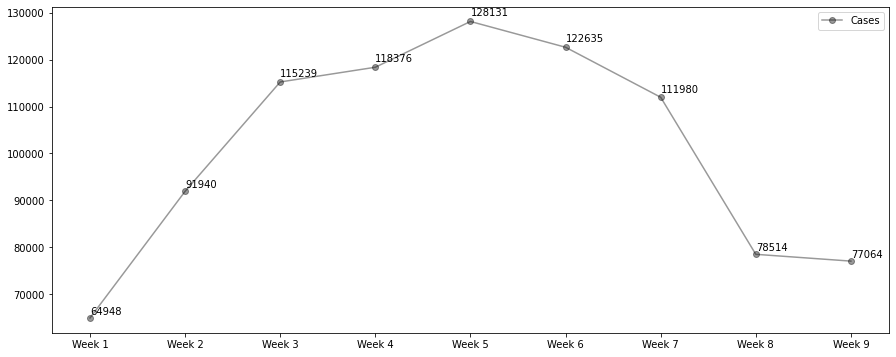

In [33]:
# Texas Covid Data from: https://covid.cdc.gov/covid-data-tracker/#trends_dailytr
#  endscases&territory-select=48&leftAxis=New_case&rightAxis=select
tx_covid_df = pd.read_csv("data/covid_data/tx_covid19_cases.csv", header=2)
tx_cases_df = str_to_date(tx_covid_df, 'Date', '%b %d %Y')
tx_cases_df

tx_cases_fig, tx_cases_axs = plt.subplots(figsize=(15,6))
cdc_state_case_visualization(tx_cases_df, tx_date_list, tx_x_list, tx_x_labels, 'Texas', tx_cases_axs)

In [140]:
import pandas as pd

In [75]:
marin_temp = pd.read_json("data/tweets/2021-08-01_2021-08-08/ca_tweets/Marin.json", lines = True)

marin = marin_temp[['renderedContent', 'hashtags']]

# marin = marin_temp.drop(columns={'url', 'date', 'content', 'id', 'user', 'replyCount',
#        'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang',
#        'source', 'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
#        'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
#        'inReplyToUser', 'mentionedUsers', 'coordinates', 'place',
#        'cashtags'})

print(marin.columns)


# apply filter method to find out tone of tweet, for brevity consider the temporary column 'tone'
marin['tone'] = [3, 4, 5, 2, 2, 4, 2]

Index(['renderedContent', 'hashtags'], dtype='object')


<ipython-input-145-f4227c72497c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marin['tone'] = [3, 4, 5, 2, 2, 4, 2]


# References

California Counties: https://www.mapsofworld.com/usa/states/california/california-county-map.html

Florida Counties: https://www.mapsofworld.com/usa/states/florida/florida-county-map.html

New York Counties: https://www.mapsofworld.com/usa/states/new-york/new-york-county-map.html

Texas Counties: https://www.mapsofworld.com/usa/states/texas/texas-county-map.html